In [16]:
import torch
import numpy as np
from copy import deepcopy
from typing import OrderedDict
from recovering import label_recovery
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
import lpips
from torchvision import transforms
from matplotlib import pyplot as plt
loss_fn = lpips.LPIPS(net='alex')
seed=2023
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [17]:
CONFIG=OrderedDict(device=torch.device('cuda:0'),
    dataset="flowers",
    network="fc",
    opt="lbfgs",
    type='label_smooth',
    pretrained=False,
    lr=0.5,
    bound=100,
    iteration=200,
    initia=1.,
    coefficient=1)
test=label_recovery(CONFIG)
test.datadir='/home/yanbo.wang/'+test.datadir
test.datalist='/home/yanbo.wang/'+test.datalist

训练得到结果进行比对

In [18]:
prob=np.random.uniform(0,0.5)
test.size=(64,64)
print(prob)
test.setup(210,prob)

0.16099415199598388


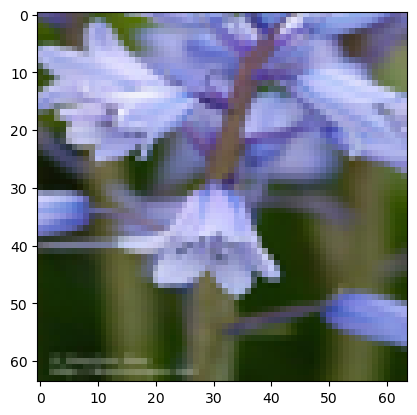

In [19]:
plt.imshow(test.tp(test.origin_data.reshape((3,64,64))))

直接image.open过程中resize，之后transform只归一化

In [20]:
test.label_reco()

skip!
skip!
skip!
skip!
skip!
skip!
skip!
skip!
flip!
epoch is 33


3.437840290221317e-10

adding trick to optimize the optimization process

In [21]:
params=dict(test.net.named_parameters())
#print(test.input_ground_truth-test.recover_tensor.mean())
#print(test.recover_tensor)

需要对得到的vector与真实vector进行比对，确保relu变0的都被过滤了

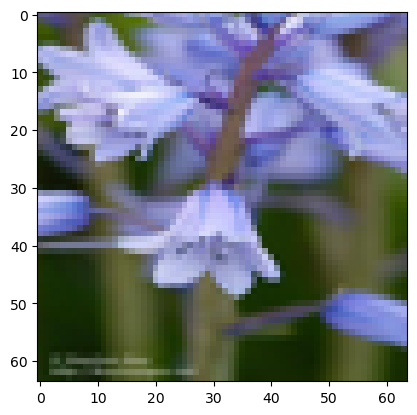

In [22]:
pi_yi=torch.div(test.gradient,test.recover_tensor).nanmean(1)
result3=deepcopy(test.recover_tensor).reshape(1,-1)
result3.require_grad_=True
params["fc4.weight"].data.shape
#pi_yi.reshape(1,-1).shape
result3.grad=torch.mm(pi_yi.reshape(1,-1),params["fc4.weight"].data)
for index,i in enumerate(result3[0]):
    if i==0:
        result3.grad[0][index]=0 
fc3_list=[]
for index,i in enumerate(params["fc3.weight"].grad.cpu()):
    if i.sum()!=0:
        fc3_list.append(np.array(i/result3.grad[0][index].cpu()))
    else:
        result3.grad[0][index]=0
result2=torch.Tensor(np.array(fc3_list).mean(axis=0)).reshape(1,-1)  
result2.requires_grad_=True
result2.grad=torch.mm(result3.grad.cpu(),params["fc3.weight"].data.cpu())
for index,i in enumerate(result2[0]):
    if i==0:
        result2.grad[0][index]=0 
fc2_list=[]
for index,i in enumerate(params["fc2.weight"].grad.cpu()):
    if i.sum()!=0:
        fc2_list.append(np.array(i/result2.grad[0][index]))
result1=torch.Tensor(np.array(fc2_list).mean(axis=0)).reshape(1,-1)  
result1.requires_grad_=True
result1.grad=torch.mm(result2.grad,params["fc2.weight"].data.cpu())
for index,i in enumerate(result1[0]):
    if i==0:
        result1.grad[0][index]=0 
fc1_list=[]
for index,i in enumerate(params["fc1.weight"].grad.cpu()):
    if i.sum()!=0:
        fc1_list.append(np.array(i/result1.grad[0][index]))
result0=torch.Tensor(np.array(fc1_list).mean(axis=0)).reshape(1,-1) 
result0=result0.reshape(3,64,64)  
pil_image=test.tp(result0)
plt.imshow(pil_image)

In [23]:
psnr=PSNR(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(pil_image),data_range=256)
ssim=SSIM(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(pil_image),channel_axis=2)
test.tp(test.origin_data.reshape((3,64,64))).save('gt.jpg')
pil_image.save('fc_recovery.jpg')
lpipss=loss_fn.forward(lpips.im2tensor(lpips.load_image('gt.jpg')),lpips.im2tensor(lpips.load_image('fc_recovery.jpg')))
print(ssim)
print(psnr)
print(lpipss)

0.9997399287488395
51.27158929297897
tensor([[[[0.0011]]]], grad_fn=<AddBackward0>)


In [24]:
cost_fn='l2' 

if cost_fn=='l2':
    iteration=300
    lr=0.3
    optim_fn='lbfgs'
    verble=50
    lr_decay=True
    total_v=0
elif cost_fn=='sim':
    iteration=6000
    lr=0.1
    optim_fn='adam'
    verble=1000
    lr_decay=True
    total_v=5e-4

In [25]:
test.reconstruct(iteration=iteration, cost_fn=cost_fn, lr=lr, optim_fn=optim_fn, magnify=1,label='dlg',verble=verble,lr_decay=lr_decay,total_variation=total_v,keep=False,record_picking=True)
psnr=PSNR(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),data_range=256)
ssim=SSIM(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),channel_axis=2)
test.tp(test.dummy_data.reshape((3,64,64))).save('dlg_temp.jpg')
# lpipss=loss_fn.forward(lpips.im2tensor(lpips.load_image('gt.jpg')),lpips.im2tensor(lpips.load_image('dlg_temp.jpg')))
print(ssim)
print(psnr)
# print(lpipss)

Iter: 1; Loss: 69.74501037597656
Iter: 50; Loss: 60.308284759521484
Iter: 100; Loss: 60.308284759521484
Iter: 150; Loss: 60.308284759521484
Iter: 200; Loss: 60.308284759521484
Iter: 250; Loss: 60.308284759521484
Iter: 300; Loss: 60.308284759521484
Total time: 9.217771768569946.
0.011654671794036313
8.111240587738848


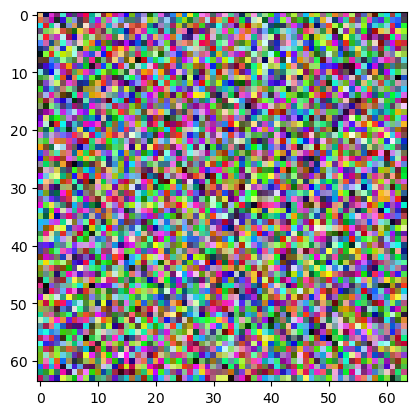

In [26]:
plt.imshow(test.tp(test.dummy_data.reshape((3,64,64))))

In [27]:
cost_fn='sim' 

if cost_fn=='l2':
    iteration=300
    lr=0.3
    optim_fn='lbfgs'
    verble=50
    lr_decay=True
    total_v=0
elif cost_fn=='sim':
    iteration=6000
    lr=0.1
    optim_fn='adam'
    verble=1000
    lr_decay=True
    total_v=5e-4

In [28]:
test.reconstruct(iteration=iteration, cost_fn=cost_fn, lr=lr, optim_fn=optim_fn, magnify=1,label='dlg',verble=verble,lr_decay=lr_decay,total_variation=total_v,keep=False,record_picking=True)
psnr=PSNR(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),data_range=256)
ssim=SSIM(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),channel_axis=2)
test.tp(test.dummy_data.reshape((3,64,64))).save('iggg.jpg')
print(ssim)
print(psnr)

Iter: 1; Loss: 1.0064572095870972


Iter: 1000; Loss: 0.0807429701089859
Iter: 2000; Loss: 0.14105316996574402
Iter: 3000; Loss: 0.030925845727324486
Iter: 4000; Loss: 0.018565509468317032
Iter: 5000; Loss: 0.01910274289548397
Iter: 6000; Loss: 0.028765931725502014
Total time: 76.91634154319763.
0.04467362412839438
8.187340251910708


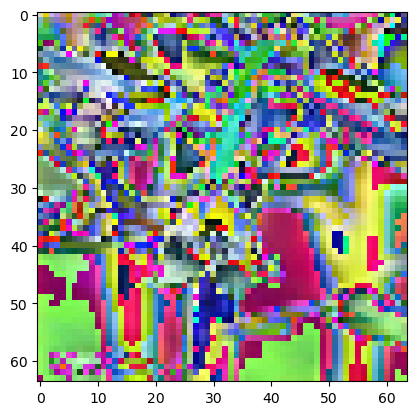

In [31]:
plt.imshow(test.tp(test.dummy_data.reshape((3,64,64))))

In [30]:
test.runningloss

0.017441533505916595